# Setup

In [16]:
#!pip install geopandas shapely pyproj pandas matplotlib owslib cartopy

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import numpy as np

from owslib.wms import WebMapService  # for GIBS later

import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams["figure.figsize"] = (10, 6)

# Dataset: Nuclear Plant Explosure

## Data Preprocessing

In [17]:
plants_df = pd.read_csv(
    "data/energy-pop-exposure-nuclear-plants-locations/energy-pop-exposure-nuclear-plants-locations_plants.csv"
)

reactors_df = pd.read_csv(
    "data/energy-pop-exposure-nuclear-plants-locations/energy-pop-exposure-nuclear-plants-locations_reactors.csv",
    encoding="latin1",      # or encoding="ISO-8859-1"
    low_memory=False
)

plants_df.head(), plants_df.columns, reactors_df.head(), reactors_df.columns

(   FID              Region                   Country         Plant  \
 0    0    Europe - Western                    SWEDEN        AGESTA   
 1    1    Europe - Western                     SPAIN       ALMARAZ   
 2    2     America - Latin                    BRAZIL         ANGRA   
 3    3  America - Northern  UNITED STATES OF AMERICA  ARKANSAS ONE   
 4    4    Europe - Western                     SPAIN          ASCO   
 
    NumReactor   Latitude  Longitude   p90_1200   p00_1200   p10_1200  ...  \
 0           1  59.206022  18.082872  187382000  188684000  188250000  ...   
 1           2  39.808100  -5.696940  136675000  147718000  163429000  ...   
 2           3 -23.007857 -44.458098   99195200  113894000  127898000  ...   
 3           2  35.310320 -93.231289  117830000  132729000  146482000  ...   
 4           2  41.200000   0.566670  271854000  287134000  308922000  ...   
 
      p10r_600     p90_300     p00_300     p10_300    p90u_300    p00u_300  \
 0   8972550.0   5013240

In [18]:
# Shapefiles (names may differ slightly – adjust to your actual filenames)
plants_gdf = gpd.read_file(
    "data/energy-pop-exposure-nuclear-plants-locations/energy-pop-exposure-nuclear-plants-locations_plants.shp"
)
reactors_gdf = gpd.read_file(
    "data/energy-pop-exposure-nuclear-plants-locations/energy-pop-exposure-nuclear-plants-locations_reactors.shp"
)

plants_gdf.head(), plants_gdf.crs, reactors_gdf.head(), reactors_gdf.crs

(          Plant  NumReactor   Latitude  Longitude     p90_1200     p00_1200  \
 0        AGESTA           1  59.206022  18.082872  187382000.0  188684000.0   
 1       ALMARAZ           2  39.808100  -5.696940  136675000.0  147718000.0   
 2         ANGRA           3 -23.007857 -44.458098   99195200.0  113894000.0   
 3  ARKANSAS ONE           2  35.310320 -93.231289  117830000.0  132729000.0   
 4          ASCO           2  41.200000   0.566670  271854000.0  287134000.0   
 
       p10_1200    p90u_1200    p00u_1200    p10u_1200  ...     p10_300  \
 0  188250000.0  121178000.0  122299000.0  122399000.0  ...   5471110.0   
 1  163429000.0   87539700.0   93943200.0  103704000.0  ...  20185200.0   
 2  127898000.0   67751500.0   77821400.0   87432200.0  ...  50210600.0   
 3  146482000.0   92609500.0  104781000.0  115697000.0  ...   6866840.0   
 4  308922000.0  190825000.0  200465000.0  215092000.0  ...  16830700.0   
 
      p90u_300    p00u_300    p10u_300   p90r_300   p00r_300   p10

## Comparison Plots

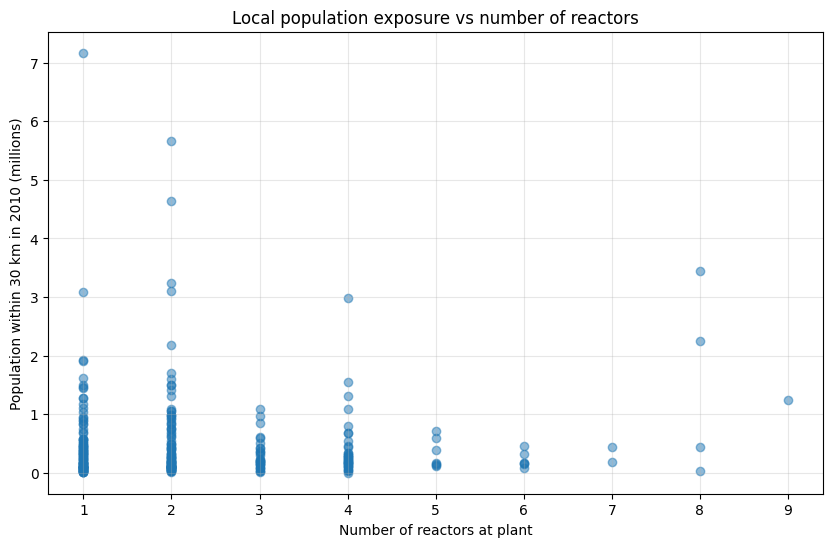

In [10]:
plants_df["p10_30"].describe()
plants_df["NumReactor"].describe()

plt.scatter(plants_df["NumReactor"], plants_df["p10_30"]/1e6, alpha=0.5)
plt.xlabel("Number of reactors at plant")
plt.ylabel("Population within 30 km in 2010 (millions)")
plt.title("Local population exposure vs number of reactors")
plt.grid(True, alpha=0.3)
plt.show()

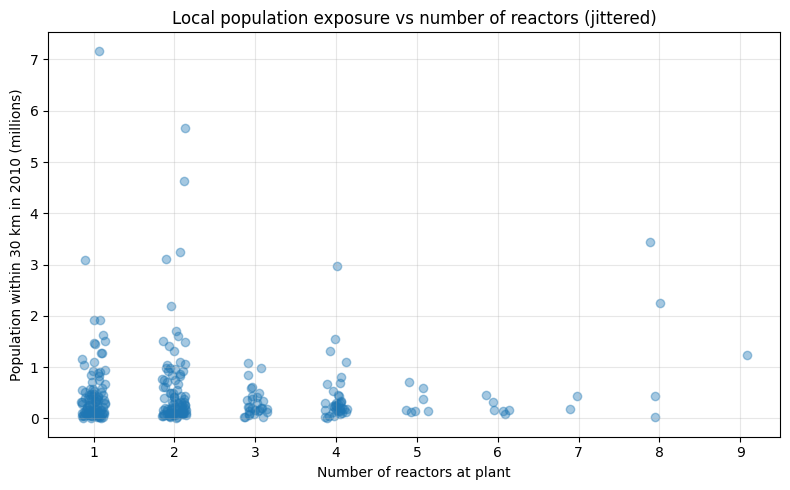

In [25]:
plants_df["pop30_m"] = plants_df["p10_30"] / 1e6

x = plants_df["NumReactor"].values
x_jitter = x + np.random.uniform(-0.15, 0.15, size=len(x))  # small horizontal noise

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x_jitter, plants_df["pop30_m"], alpha=0.4)

ax.set_xticks(sorted(plants_df["NumReactor"].unique()))
ax.set_xlabel("Number of reactors at plant")
ax.set_ylabel("Population within 30 km in 2010 (millions)")
ax.set_title("Local population exposure vs number of reactors (jittered)")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

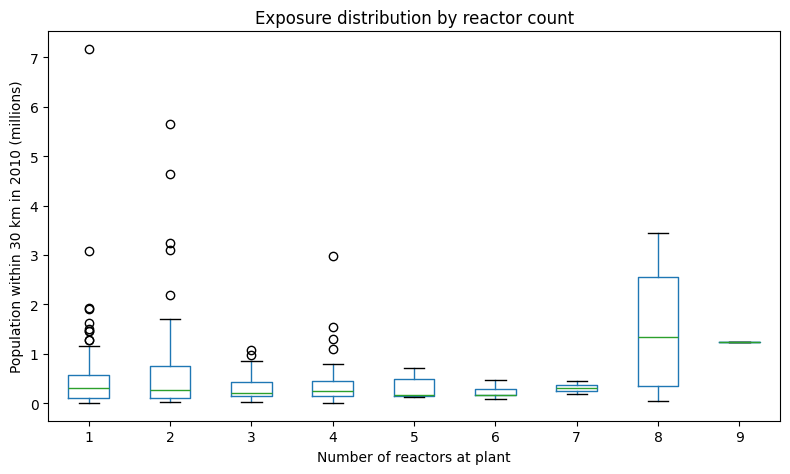

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
plants_df.boxplot(
    column="pop30_m",
    by="NumReactor",
    ax=ax,
    grid=False
)

ax.set_xlabel("Number of reactors at plant")
ax.set_ylabel("Population within 30 km in 2010 (millions)")
ax.set_title("Exposure distribution by reactor count")
plt.suptitle("")  # remove pandas default
plt.tight_layout()
plt.show()

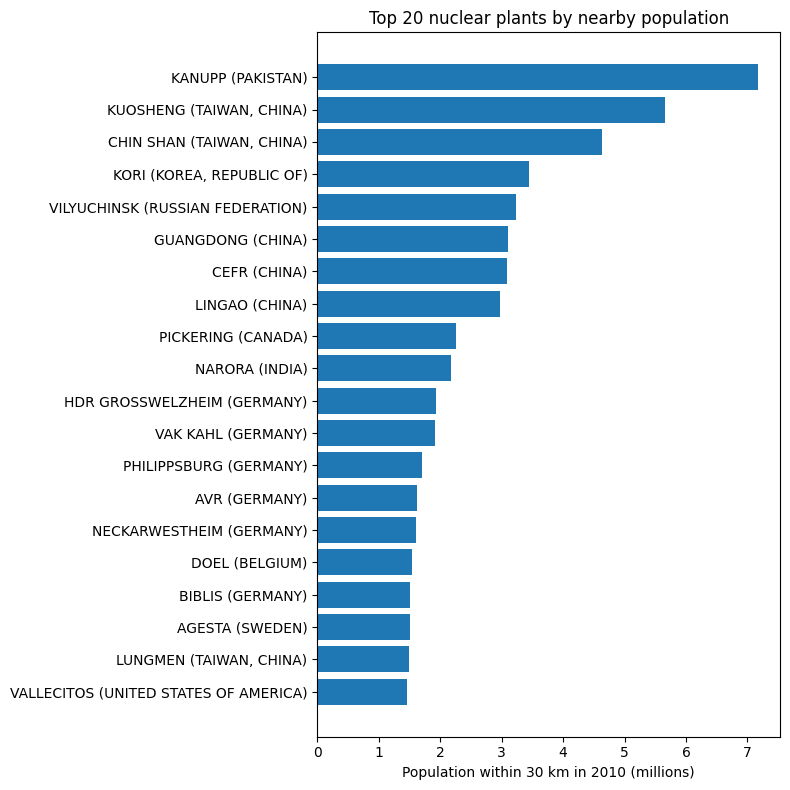

In [27]:
top = (
    plants_df.assign(pop30_m=plants_df["p10_30"] / 1e6)
             .sort_values("pop30_m", ascending=False)
             .head(20)
)

top["label"] = top["Plant"] + " (" + top["Country"] + ")"

fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(top["label"], top["pop30_m"])
ax.invert_yaxis()

ax.set_xlabel("Population within 30 km in 2010 (millions)")
ax.set_title("Top 20 nuclear plants by nearby population")
plt.tight_layout()
plt.show()

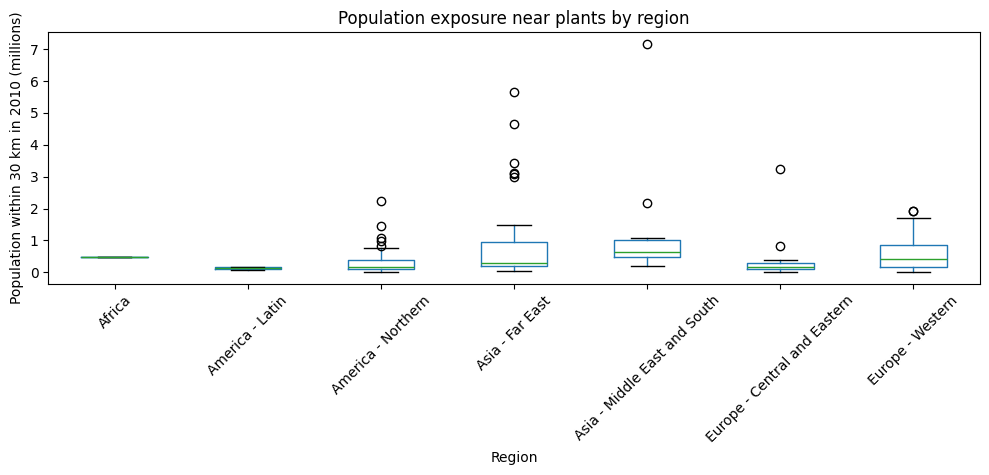

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
plants_df.assign(pop30_m=plants_df["p10_30"] / 1e6).boxplot(
    column="pop30_m", by="Region", ax=ax, rot=45, grid=False
)

ax.set_ylabel("Population within 30 km in 2010 (millions)")
ax.set_title("Population exposure near plants by region")
plt.suptitle("")
plt.tight_layout()
plt.show()

## Map Plots

In [19]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

ax = world.plot(color="lightgrey", edgecolor="white")
plants_gdf.plot(ax=ax, markersize=10, color="red", alpha=0.7)
plt.title("Global Nuclear Power Plants")
plt.show()


AttributeError: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


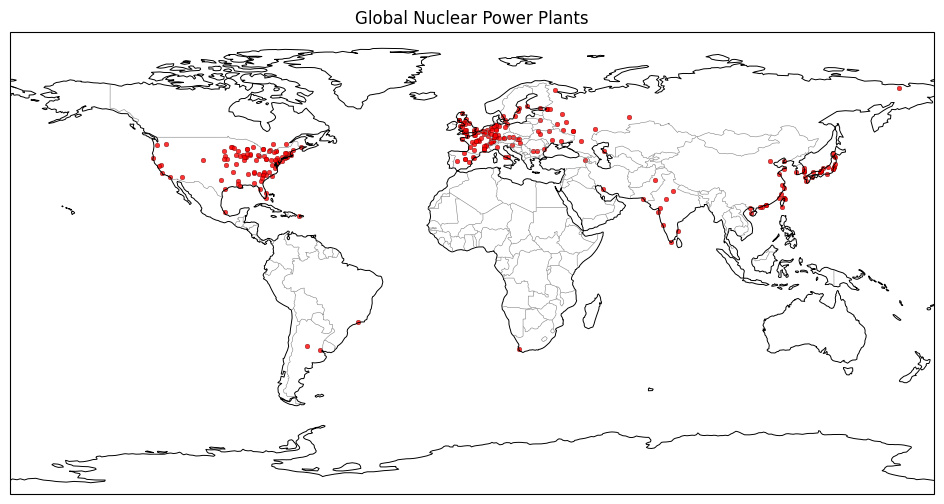

In [20]:
def plot_plants_outline():
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()

    ax.coastlines(resolution="110m", linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor="gray")

    ax.scatter(
        plants_df["Longitude"],
        plants_df["Latitude"],
        s=12,
        c="red",
        alpha=0.8,
        transform=ccrs.PlateCarree(),
        edgecolor="black",
        linewidth=0.2,
    )

    ax.set_title("Global Nuclear Power Plants")
    plt.show()

plot_plants_outline()

In [21]:
# 1. Connect to GIBS WMS (geographic projection)
wms = WebMapService(
    "https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi",
    version="1.3.0"
)

list(wms.contents.keys())[:10]  # peek at some layer names

['NASA_GIBS_EPSG4326_best',
 'Temperature',
 'MERRA2_2m_Air_Temperature_Monthly',
 'MERRA2_2m_Air_Temperature_Assimilated_Monthly',
 'MLS_Temperature_46hPa_Day',
 'MLS_Temperature_46hPa_Night',
 'GLDAS_Near_Surface_Air_Temperature_Monthly',
 'NLDAS_Near_Surface_Air_Temperature_Primary_Monthly',
 'MERRA2_Air_Temperature_250hPa_Monthly',
 'AIRS_L3_Surface_Air_Temperature_Daily_Day']

In [22]:
layer_name = "MODIS_Terra_CorrectedReflectance_TrueColor"
date = "2010-01-01"   # just pick any valid date; you can change it

bbox = (-180, -90, 180, 90)
width, height = 2048, 1024

img = wms.getmap(
    layers=[layer_name],
    styles=["default"],
    srs="EPSG:4326",
    bbox=bbox,
    size=(width, height),
    format="image/jpeg",
    transparent=True,
    time=date
)

img_arr = np.array(Image.open(BytesIO(img.read())))

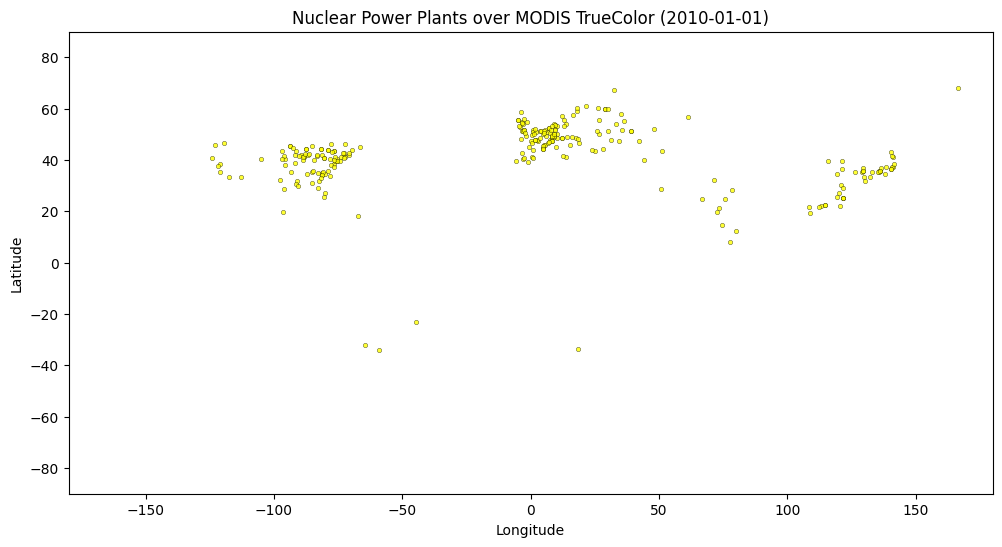

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

# GIBS image as background
ax.imshow(
    img_arr,
    extent=bbox,
    origin="upper"
)

# Overlay plant locations
ax.scatter(
    plants_df["Longitude"],
    plants_df["Latitude"],
    s=10,
    c="yellow",
    edgecolor="black",
    linewidth=0.3,
    alpha=0.8
)

ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"Nuclear Power Plants over MODIS TrueColor ({date})")
plt.show()


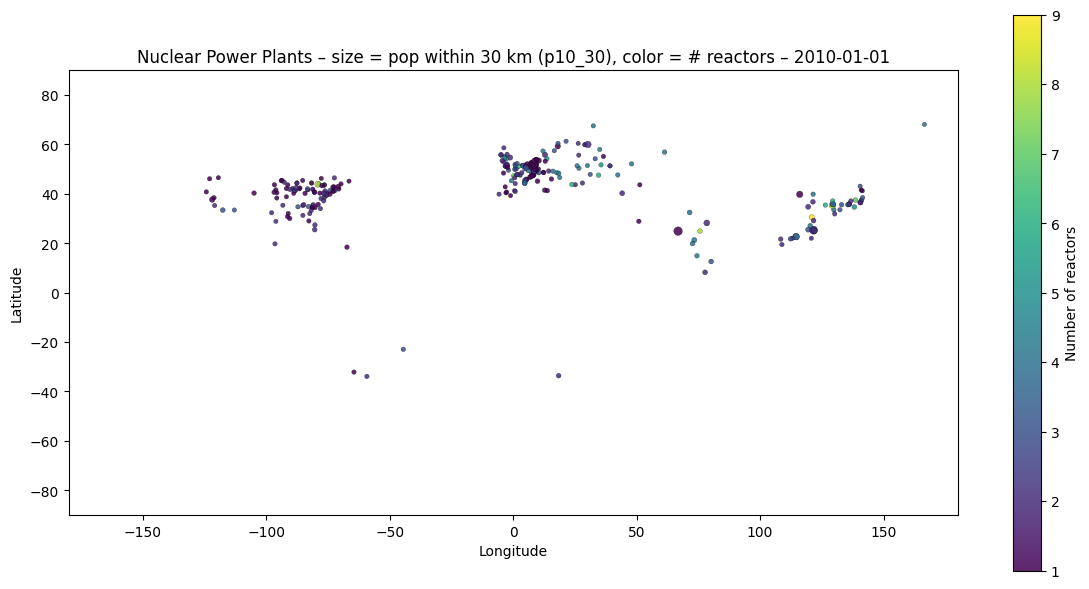

In [24]:
def plot_plants_over_gibs(
    date="2010-01-01",
    layer_name="BlueMarble_NextGeneration",
    pop_col="p10_30"  # 2010 population within 30 km
):
    # Connect to GIBS WMS
    wms = WebMapService(
        "https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi",
        version="1.3.0"
    )

    bbox = (-180, -90, 180, 90)
    width, height = 2048, 1024

    img = wms.getmap(
        layers=[layer_name],
        styles=["default"],
        srs="EPSG:4326",
        bbox=bbox,
        size=(width, height),
        format="image/jpeg",
        transparent=True,
        time=date,
    )
    img_arr = np.array(Image.open(BytesIO(img.read())))

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(img_arr, extent=bbox, origin="upper")

    # scale population so sizes are reasonable
    pop_millions = plants_df[pop_col] / 1e6
    sizes = 10 + pop_millions * 4  # tweak multiplier as needed

    sc = ax.scatter(
        plants_df["Longitude"],
        plants_df["Latitude"],
        s=sizes,
        c=plants_df["NumReactor"],
        cmap="viridis",
        alpha=0.85,
        edgecolor="black",
        linewidth=0.2,
    )

    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(
        f"Nuclear Power Plants – size = pop within 30 km ({pop_col}), "
        f"color = # reactors – {date}"
    )

    cbar = plt.colorbar(sc, ax=ax, label="Number of reactors")
    plt.tight_layout()
    plt.show()

plot_plants_over_gibs()